## Importando pacotes, bibliotecas, módulos, classes e métodos necessários

In [1]:
# Bibliotecas de sistema
import os
import time
import datetime
import pickle

# Bibliotecas de manipulação de dados
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)

# Modulos de visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Classes de preprocessamento
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

# Modelos de Machine Learning convencionais
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, 
                              VotingClassifier, BaggingClassifier)
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Modelos de Deep Learning
from keras import (models, layers)

# Métodos de medição de performance
from sklearn.metrics import (confusion_matrix,
                             accuracy_score)

#### Semente para reprodução dos resultados

In [2]:
SEED = 123

## 1 - Análise Exploratória de Dados

#### Carregando a base de treino

In [3]:
df = pd.read_csv('train_data.csv', sep=';')

In [4]:
df.head()

,periodo,dt_emissao,dt_vencimento,bill_period,dt_ativacao_conta,dias_ate_vencimento,bill_disp_meth,valor_fatura,dif_perc_atual_ult_mes,ticket_medio_ult_3_meses,empresa_grupo,dt_ativacao_cliente,email_cadastrado,financial_score_classif,dsc_frm_notificacao_ptl,numero_recebimento_sms_cadastrado,genero_cliente,internet_casa,internet_escritorio,tem_divida_atraso,divida_antiga_sobre_fatura,idade_base_cliente,idade_base_conta,perc_pago_prazo,flag_car
0,202106,2021-06-03,2021-06-21,4,1998-10-06,18,1,65.41,1.000000,65.410000,0,2001-01-27,1,4,1,1,1,-3,-3,0,0.00000,20,23,1,0
1,202104,2021-04-03,2021-04-16,3,2020-09-22,13,1,94.93,1.054660,93.290000,1,2010-12-07,1,2,1,1,2,-3,-3,1,2.94996,11,1,0,1
2,202104,2021-04-03,2021-04-16,3,2015-03-14,13,3,107.16,1.000000,107.160000,1,2012-07-18,1,4,1,1,1,-3,-3,0,0.00000,9,6,1,0
3,202103,2021-03-03,2021-03-16,3,2015-08-07,13,1,78.66,0.998730,78.736666,1,2001-01-27,1,1,1,1,1,-3,-3,0,0.00000,20,6,0,0
4,202105,2021-05-12,2021-05-28,7,2013-04-30,16,0,56.46,1.001063,56.426666,1,2001-01-27,1,4,1,1,1,-3,-3,0,0.00000,20,8,"0,333333333333333",0


### 1.1 - Sobre os Dados

- **periodo**: Período ao qual o arquivo de Contas a Receber se refere.
- **dt_emissao**: Data de emissão da fatura.
- **dt_vencimento**: Data de vencimento da fatura.
- **bill_period**: Número do ciclo de faturamento.
- **dt_ativacao_conta**: Data de ativação da conta de faturamento.
- **dias_ate_vencimento**: Diferença em dias entre emissão e vencimento. 
- **bill_disp_meth**: Modo de envio da fatura.
- **valor_fatura**: Valor da fatura.
- **dif_perc_atual_ult_mes**: (Coluna Gerada) Diferença percentual entre o último faturamento da conta contra o faturamento atual.
- **ticket_medio_ult_3_meses**: (Coluna Gerada) Média de faturamento mensal da conta nos últimos 3 meses.
- **empresa_grupo**: (Informação Confidencial).
- **dt_ativacao_cliente**: Data em que o cliente entrou na base.
- **email_cadastrado**: Possui endereço de e-mail cadastrado (1-Sim 0-Não).
- **financial_score_classif**: Score financeiro do cliente - Essa informação é calculada automaticamente pelo setor de crédito do cliente (1-Inadimplente 2-Insolvente 3-Renegociação 4-Adimplente 0-N/A).
- **dsc_frm_notificacao_ptl**: Canal de envio de notificação de atraso/emissão de fatura (1-SMS 2-Email 3-Não deseja ser notificado 4-Mensagem de áudio 0-N/A).
- **numero_recebimento_sms_cadastrado**: Possui número de telefone cadastrado para recebimento de mensagens (1-Sim 0-Não).
- **genero_cliente**: Gênero do cliente (1-Masculino 2-Feminino).
- **internet_casa**: Possui plano de internet em casa.
- **internet_escritorio**: Possui plano de internet no escritório.
- **tem_divida_atraso**: (Coluna Gerada) O cliente possui alguma dívida em atraso olhando o histórico anterior de Contas a Receber (1-Sim 0-Não).
- **divida_antiga_sobre_fatura**: (Coluna Gerada) Razão entre valor da dívida em atraso do mês anterio e valor da fatura.
- **idade_base_cliente**: (Coluna Gerada) Idade em anos em que o consumidor é cliente da empresa.
- **idade_base_conta**: (Coluna Gerada) Idade em anos em que a conta foi criada.
- **perc_pago_prazo**: (Coluna Gerada) Percentual de faturas pagas no prazo nos últimos 3 meses.
- **flag_car**: (Coluna Gerada) Rótulo final indicando se a fatura foi para a base de Contas a Receber (1-Sim 0-Não).

#### 1.1.1 - Query

(Algumas informações foram omitidas)

``` mysql
use XXX;

declare @periodos table (
	line int,
	periodo char(6)
)
insert into @periodos
values
	(1, '202103'),
	(2, '202104'),
	(3, '202105'),
	(4, '202106')
;

declare @counter int = 1;

drop table if exists ##DADOS_PREVISAO_CAR;

while @counter <= (select count(*) from @periodos)
begin
	
	declare @data_base varchar(max) = (select periodo from @periodos where line = @counter)
	
	/*-------------- TICKET MÉDIO --------------*/
	drop table if exists ##TICKET_MEDIO;
	select
		numero_cliente,
		numero_conta,
		isnull(
			sum(case when periodo = @data_base then total_faturado_atual else null end)/
			sum(case when datediff(month, datefromparts(left(periodo, 4), right(periodo, 2), 1), datefromparts(left(@data_base, 4), right(@data_base, 2), 1)) = 1 then total_faturado_ult_3_meses else null end)
		, 0) as dif_perc_atual_ult_mes,
		isnull(sum(total_faturado_ult_3_meses)/count(case when periodo <> @data_base then 1 else null end), 0) as ticket_medio_ult_3_meses
	into ##TICKET_MEDIO
	from
		(
			select 
				format(dt_emissao, 'yyyyMM') as periodo, 
				numero_cliente, 
				numero_conta, 
				sum(case when datediff(month, dt_emissao, eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)) = 0 then valor_fatura else null end) as total_faturado_atual,
				sum(case when datediff(month, dt_emissao, eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)) between 1 and 3 then valor_fatura else null end) as total_faturado_ult_3_meses
			from TB_TRAT_FATURAMENTO_DW_V2
			where 1 = 1
				and valor_fatura > 0
				and datediff(
						month,
						dt_emissao,
						eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)
						) between 0 and 3
			group by format(dt_emissao, 'yyyyMM'), numero_cliente, numero_conta
		) as f
	group by numero_cliente, numero_conta



	/*-------------- PERFIL PAGAMENTOS --------------*/
	drop table if exists ##PERFIL_PAGAMENTO;
	select
		fat.numero_cliente,
		fat.numero_conta,
		count(*) as qnt_faturas,
		count(case when dt_pagamento is not null and datediff(day, dt_vencimento, dt_pagamento) <= 0 then 1 else null end) as qnt_pago_prazo,
		isnull(cast(count(case when dt_pagamento is not null and datediff(day, dt_vencimento, dt_pagamento) <= 0 then 1 else null end) as float)/cast(count(*) as float), 0) as perc_pago_prazo
	into ##PERFIL_PAGAMENTO
	from
		(
			select 
				*
			from TB_TRAT_FATURAMENTO_DW as fat
			where 1 = 1
				and valor_fatura > 0
				and datediff(
						month,
						dt_emissao,
						eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)
						) between 1 and 3
		) as fat
	left join
		(
			select
				numero_cliente,
				--numero_conta,
				numero_fatura,
				min(data_pagamento) as dt_pagamento,
				sum(valor_pagamento) as valor_pagamento
			from
				(
					select
						numero_cliente,
						numero_conta,
						numero_fatura,
						data_pagamento,
						valor_pagamento
					from TB_TRAT_PAGAMENTOS_DW
					where 1 = 1
						and datediff(month, data_pagamento, eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)) <= 3
						and sistema_origem_faturamento = 'XXX'
					group by
						numero_cliente,
						numero_conta,
						numero_fatura,
						data_pagamento,
						valor_pagamento
				) as pag
			group by
				numero_cliente,
				--numero_conta,
				numero_fatura
		) as pag
	on 1 = 1
		and fat.numero_cliente = pag.numero_cliente
		and fat.numero_fatura = pag.numero_fatura
	group by
		fat.numero_cliente,
		fat.numero_conta


	if @counter = 1
	begin
		
		/*-------------- DADOS --------------*/
		select
			@data_base as periodo,
			f.*,
			case when div_antiga.cpf_cnpj is not null then div_antiga.tem_divida_atraso else 0 end as tem_divida_atraso,
			replace(isnull(case when div_antiga.cpf_cnpj is not null then div_antiga.total_divida else 0 end, 0) / f.valor_fatura, ',', '.') as divida_antiga_sobre_fatura,
			datediff(year, dt_ativacao_cliente, dt_emissao) as idade_base_cliente,
			datediff(year, dt_ativacao_conta, dt_emissao) as idade_base_conta,
			case when perf.numero_cliente is null then 1 else perf.perc_pago_prazo end as perc_pago_prazo,
			case when car.cpf_cnpj is null then 0 else 1 end as flag_car
		into ##DADOS_PREVISAO_CAR
		from
			(
				select
					/*BASE DE FATURAMENTO*/
					f.numero_cliente,
					f.numero_conta,
					f.account_no,
					f.numero_fatura,
					f.dt_emissao,
					f.dt_vencimento,
					f.bill_period,
					f.dt_ativacao as dt_ativacao_conta,
					--case when datediff(month, f.dt_emissao, f.dt_vencimento) = 0 then 1 else 0 end as vencimento_no_mes,
					datediff(day, f.dt_emissao, f.dt_vencimento) as dias_ate_vencimento,
					f.bill_disp_meth,
					f.valor_fatura,
					f.dif_perc_atual_ult_mes,
					f.ticket_medio_ult_3_meses,
					case
						when upper(f.empresa_grupo) = 'XXX' then 1 
						when upper(f.empresa_grupo) = 'XXX' or upper(empresa_grupo) = 'XXX' then 2 
						when upper(f.empresa_grupo) = 'XXX' then 3
						when upper(f.empresa_grupo) = 'XXX' then 4
						when upper(f.empresa_grupo) = 'XXX' then 5
						else 0 /*Null*/
					end as empresa_grupo,

					/*BASE DE CLIENTES*/
					c.dt_ativacao as dt_ativacao_cliente,
					case when c.email = '-1' then 0 else 1 end as email_cadastrado,
					case 
						when c.financial_score_classif = 'INADIMPLENTE' then 1
						when c.financial_score_classif = 'INSOLVENTE' then 2
						when c.financial_score_classif = 'RENEG' then 3
						when c.financial_score_classif = 'ADIMPLENTE' then 4
						else 0 /*Null*/
					end as financial_score_classif,
					case 
						when c.dsc_frm_notificacao_ptl = 'SMS' then 1
						when c.dsc_frm_notificacao_ptl = 'E-MAIL' then 2
						when c.dsc_frm_notificacao_ptl = 'NAO TEM CONTATO/NAO QUER RECEBER PROTOCOLO' then 3
						when c.dsc_frm_notificacao_ptl = 'MENSAGEM DE AUDIO' then 4
						else 0 /*Null*/
					end as dsc_frm_notificacao_ptl,
					case when c.num_tel_rcb_sms is null then 0 else 1 end as numero_recebimento_sms_cadastrado,
					case 
						when c.genero_cliente = 'MASCULINO' then 1
						when c.genero_cliente = 'FEMININO' then 2
						else 0 /*Null*/
					end as genero_cliente,
					c.internet_casa,
					c.internet_escritorio
				from
					( /*Base de Faturamento*/
						select 
							f.*,
							t.dif_perc_atual_ult_mes,
							t.ticket_medio_ult_3_meses
						from TB_TRAT_FATURAMENTO_DW_V2 as f
						left join ##TICKET_MEDIO as t
						on 1 = 1
							and f.numero_cliente = t.numero_cliente
							and f.numero_conta = t.numero_conta
						inner join
							( /*Puxa somente contas que faturaram pelo menos no mês anterior*/
								select
									numero_cliente, numero_conta, account_no
								from TB_TRAT_FATURAMENTO_DW_V2
								where 1 = 1
									and datediff(month, dt_emissao, eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)) = 1
								group by numero_cliente, numero_conta, account_no
							) as fat_anterior
						on 1 = 1
							and f.numero_cliente = fat_anterior.numero_cliente
							and f.numero_conta = fat_anterior.numero_conta
							and f.account_no = fat_anterior.account_no
						where 1 = 1
							and format(dt_emissao, 'yyyyMM') = @data_base
							and valor_fatura > 0
							and dt_vencimento <= eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0) /*Somente Faturas que vencem no mês*/
					) as f
				inner join 
					(
						select *
						from TB_TRAT_CLIENTES_DW
						where 1 = 1
							and segmento_grupo = 'XXX'
					) as c
				on
					f.numero_cliente = c.numero_cliente
			) as f
		left join
			(	
				select *
				from TB_STG_CAR_AGING_CONSOLIDADO_SISTEMA
				where 1 = 1
					and periodo = @data_base
					and sistema = 'XXX'
			) as car
		on 1 = 1
			and f.numero_cliente = car.cpf_cnpj
			and f.account_no = car.account_no
			and f.numero_fatura = car.num_fatura
		left join
			(
				select 
					cpf_cnpj,
					account_no,
					case
						when sum( case when datediff(day, eomonth(datefromparts(left(periodo, 4), right(periodo, 2), 1), 0), cast(vencimento as date)) < 0 then cast(replace(saldo_aberto, ',', '.') as float) else null end ) > 0 then 1 else 0
					end as tem_divida_atraso,
			
					sum( case when datediff(day, eomonth(datefromparts(left(periodo, 4), right(periodo, 2), 1), 0), cast(vencimento as date)) < 0 then cast(replace(saldo_aberto, ',', '.') as float) else null end ) as total_divida

				from TB_STG_CAR_AGING_CONSOLIDADO_SISTEMA
				where 1 = 1
					and periodo = format(dateadd(month, -1, datefromparts(left(@data_base, 4), right(@data_base, 2), 1)), 'yyyyMM')
					and sistema = 'XXX'
				group by cpf_cnpj, account_no
			) as div_antiga
		on 1 = 1
			and f.numero_cliente = div_antiga.cpf_cnpj
			and f.account_no = div_antiga.account_no

		left join ##PERFIL_PAGAMENTO as perf
		on 1 = 1
			and f.numero_cliente = perf.numero_cliente
			and f.numero_conta = perf.numero_conta

	end

	else
	begin
		insert into ##DADOS_PREVISAO_CAR
			/*-------------- DADOS --------------*/
			select
				@data_base as periodo,
				f.*,
				case when div_antiga.cpf_cnpj is not null then div_antiga.tem_divida_atraso else 0 end as tem_divida_atraso,
				replace(isnull(case when div_antiga.cpf_cnpj is not null then div_antiga.total_divida else 0 end, 0) / f.valor_fatura, ',', '.') as divida_antiga_sobre_fatura,
				datediff(year, dt_ativacao_cliente, dt_emissao) as idade_base_cliente,
				datediff(year, dt_ativacao_conta, dt_emissao) as idade_base_conta,
				case when perf.numero_cliente is null then 1 else perf.perc_pago_prazo end as perc_pago_prazo,
				case when car.cpf_cnpj is null then 0 else 1 end as flag_car
			from
				(
					select
						/*BASE DE FATURAMENTO*/
						f.numero_cliente,
						f.numero_conta,
						f.account_no,
						f.numero_fatura,
						f.dt_emissao,
						f.dt_vencimento,
						f.bill_period,
						f.dt_ativacao as dt_ativacao_conta,
						--case when datediff(month, f.dt_emissao, f.dt_vencimento) = 0 then 1 else 0 end as vencimento_no_mes,
						datediff(day, f.dt_emissao, f.dt_vencimento) as dias_ate_vencimento,
						f.bill_disp_meth,
						f.valor_fatura,
						f.dif_perc_atual_ult_mes,
						f.ticket_medio_ult_3_meses,
						case
							when upper(f.empresa_grupo) = 'XXX' then 1
							when upper(f.empresa_grupo) = 'XXX' or upper(empresa_grupo) = 'XXX' then 2
							when upper(f.empresa_grupo) = 'XXX' then 3
							when upper(f.empresa_grupo) = 'XXX' then 4
							when upper(f.empresa_grupo) = 'XXX' then 5
							else 0 /*Null*/
						end as empresa_grupo,

						/*BASE DE CLIENTES*/
						c.dt_ativacao as dt_ativacao_cliente,
						case when c.email = '-1' then 0 else 1 end as email_cadastrado,
						case 
							when c.financial_score_classif = 'INADIMPLENTE' then 1
							when c.financial_score_classif = 'INSOLVENTE' then 2
							when c.financial_score_classif = 'RENEG' then 3
							when c.financial_score_classif = 'ADIMPLENTE' then 4
							else 0 /*Null*/
						end as financial_score_classif,
						case 
							when c.dsc_frm_notificacao_ptl = 'SMS' then 1
							when c.dsc_frm_notificacao_ptl = 'E-MAIL' then 2
							when c.dsc_frm_notificacao_ptl = 'NAO TEM CONTATO/NAO QUER RECEBER PROTOCOLO' then 3
							when c.dsc_frm_notificacao_ptl = 'MENSAGEM DE AUDIO' then 4
							else 0 /*Null*/
						end as dsc_frm_notificacao_ptl,
						case when c.num_tel_rcb_sms is null then 0 else 1 end as numero_recebimento_sms_cadastrado,
						case 
							when c.genero_cliente = 'MASCULINO' then 1
							when c.genero_cliente = 'FEMININO' then 2
							else 0 /*Null*/
						end as genero_cliente,
						c.internet_casa,
						c.internet_escritorio
					from
						( /*Base de Faturamento*/
							select 
								f.*,
								t.dif_perc_atual_ult_mes,
								t.ticket_medio_ult_3_meses
							from TB_TRAT_FATURAMENTO_DW_V2 as f
							left join ##TICKET_MEDIO as t
							on 1 = 1
								and f.numero_cliente = t.numero_cliente
								and f.numero_conta = t.numero_conta
							inner join
								( /*Puxa somente contas que faturaram pelo menos no mês anterior*/
									select
										numero_cliente, numero_conta, account_no
									from TB_TRAT_FATURAMENTO_DW_V2
									where 1 = 1
										and datediff(month, dt_emissao, eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0)) = 1
									group by numero_cliente, numero_conta, account_no
								) as fat_anterior
							on 1 = 1
								and f.numero_cliente = fat_anterior.numero_cliente
								and f.numero_conta = fat_anterior.numero_conta
								and f.account_no = fat_anterior.account_no
							where 1 = 1
								and format(dt_emissao, 'yyyyMM') = @data_base
								and valor_fatura > 0
								and dt_vencimento <= eomonth(datefromparts(left(@data_base, 4), right(@data_base, 2), 1), 0) /*Somente Faturas que vencem no mês*/
						) as f
					inner join 
						(
							select *
							from TB_TRAT_CLIENTES_DW
							where 1 = 1
								and segmento_grupo = 'XXX'
						) as c
					on
						f.numero_cliente = c.numero_cliente
				) as f
			left join
				(	
					select *
					from TB_STG_CAR_AGING_CONSOLIDADO_SISTEMA
					where 1 = 1
						and periodo = @data_base
						and sistema = 'XXX'
				) as car
			on 1 = 1
				and f.numero_cliente = car.cpf_cnpj
				and f.account_no = car.account_no
				and f.numero_fatura = car.num_fatura
			left join
				(
					select 
						cpf_cnpj,
						account_no,
						case
							when sum( case when datediff(day, eomonth(datefromparts(left(periodo, 4), right(periodo, 2), 1), 0), cast(vencimento as date)) < 0 then cast(replace(saldo_aberto, ',', '.') as float) else null end ) > 0 then 1 else 0
						end as tem_divida_atraso,
			
						sum( case when datediff(day, eomonth(datefromparts(left(periodo, 4), right(periodo, 2), 1), 0), cast(vencimento as date)) < 0 then cast(replace(saldo_aberto, ',', '.') as float) else null end ) as total_divida

					from TB_STG_CAR_AGING_CONSOLIDADO_SISTEMA
					where 1 = 1
						and periodo = format(dateadd(month, -1, datefromparts(left(@data_base, 4), right(@data_base, 2), 1)), 'yyyyMM')
						and sistema = 'XXX'
					group by cpf_cnpj, account_no
				) as div_antiga
			on 1 = 1
				and f.numero_cliente = div_antiga.cpf_cnpj
				and f.account_no = div_antiga.account_no

			left join ##PERFIL_PAGAMENTO as perf
			on 1 = 1
				and f.numero_cliente = perf.numero_cliente
				and f.numero_conta = perf.numero_conta
	end

	set @counter = @counter + 1
end



select top 100000 *
from ##DADOS_PREVISAO_CAR
order by newid() /*Retorna os resultados randomizados*/
    
```

#### Deletando colunas que não serão usadas

In [5]:
drop_cols = ['periodo', 'dt_emissao', 'dt_vencimento', 'dt_ativacao_conta',
             'dt_ativacao_cliente', 'internet_casa', 'internet_escritorio']
df.drop(columns=drop_cols, inplace=True)

### 1.2 - Valores Faltantes
Obs.: Não haverão, pois a substituição de valores faltantes foi realizada durante a modelagem de dados.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   bill_period                        100000 non-null  int64  
 1   dias_ate_vencimento                100000 non-null  int64  
 2   bill_disp_meth                     100000 non-null  int64  
 3   valor_fatura                       100000 non-null  float64
 4   dif_perc_atual_ult_mes             100000 non-null  float64
 5   ticket_medio_ult_3_meses           100000 non-null  float64
 6   empresa_grupo                      100000 non-null  int64  
 7   email_cadastrado                   100000 non-null  int64  
 8   financial_score_classif            100000 non-null  int64  
 9   dsc_frm_notificacao_ptl            100000 non-null  int64  
 10  numero_recebimento_sms_cadastrado  100000 non-null  int64  
 11  genero_cliente                     10000

#### Convertendo perc_pago_prazo em float

In [7]:
df['perc_pago_prazo'] = df['perc_pago_prazo'].str.replace(',', '.').astype(float)

### 1.3 - Matriz de Correlação

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

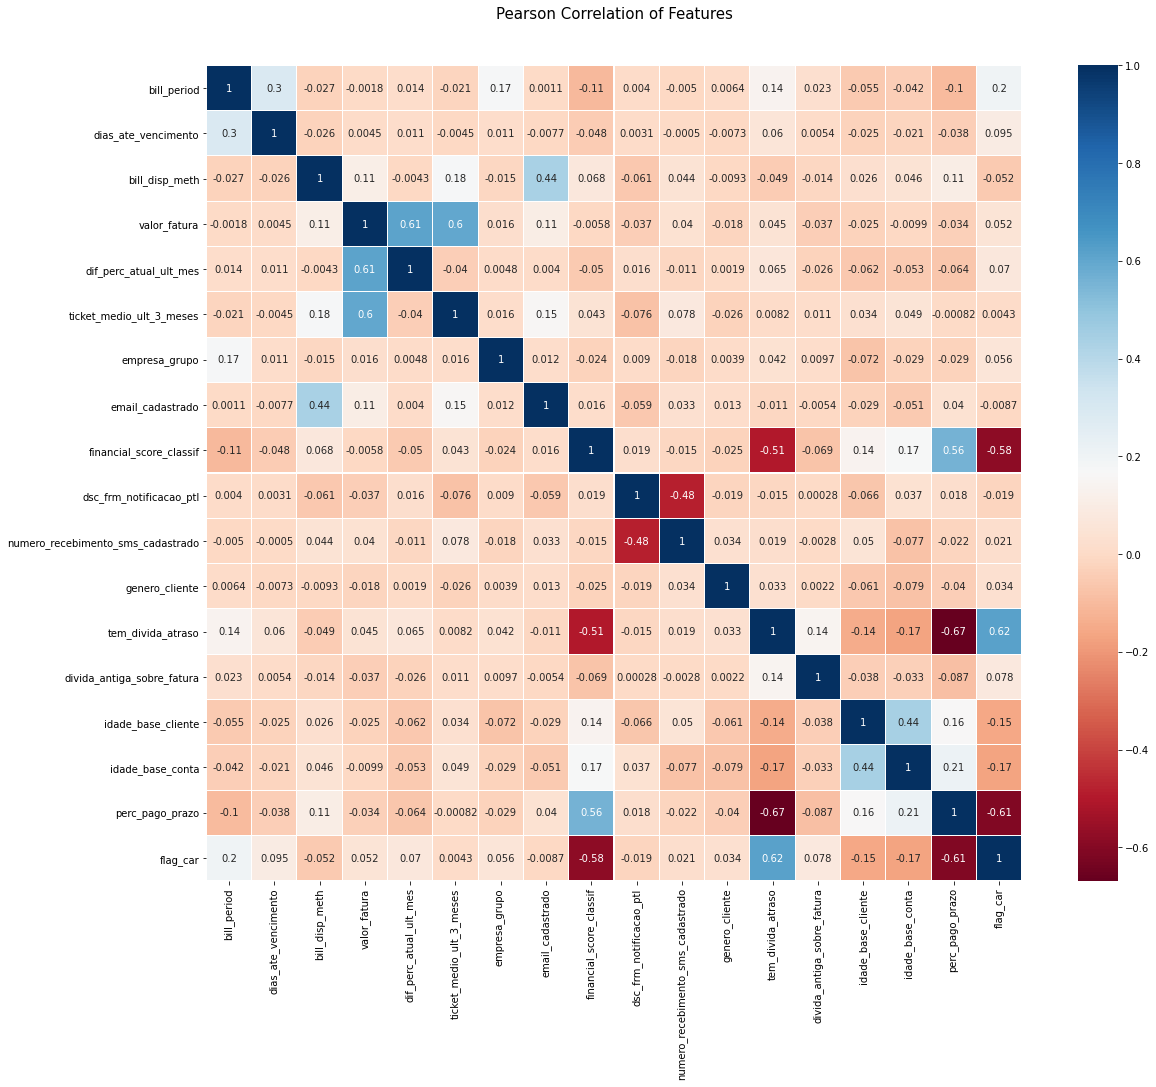

In [8]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 15))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Comentários: 

A matriz de correlação é uma ótima ferramenta de visualização de dados para identificar relacionamentos entre características dos dados que possivelmente o time de negócios não havia previamente mapeado. Seu valor vai de -1 a 1 indicando uma correlação inversamente perfeita a uma correlação diretamente perfeita respectivamente. Uma correlação inversa indica que enquanto a variável y cresce a variável x decresce, ou seja, plotando os dados a linha de tendência linear possuiria inclinação negativa. Já uma correlação direta indica que ambas as variáveis crescem proporcionalmente de modo que a linha de tendência possuiria inclinação positiva. Já o valor p = 0 indica que não há qualquer correlação linear entre as variáveis x e y de modo que sua relação não pode ser expressa de maneira linear.

- Parece que há correlação inversa entre o score financeiro do cliente (financial_score_classif) e a entrada da fatura no CAR (flag_car) no valor de p = -0,58. O score financeiro é na verdade uma variável categórica e sua conversão em número foi feita de tal maneira que 4 (maior valor) representasse a melhor situação possível, ou seja, que o cliente esteja adimplente segundo o time de crédito. O flag_car, no entanto, não segue a mesma lógica, pois 1 indica que a fatura não foi paga e teve entrada no CAR e 0 indica que a fatura foi quitada antes de dar entrada no CAR. Deste modo, ambas as colunas possuem de fato possuem alguma forma de relação e que esta respeita o fato de quanto maior o score financeiro menor será o flag_car, pois será menos provável que o cliente não pagará a fatura.

- Parece que há alguma correlação direta entre o fato da fatura não ser paga (flag_car) e o fato do cliente possuir alguma dívida em atraso (tem_divida_atraso). Tal fato está expresso pelo valor de p = 0,62.

- Parece que há alguma correlação inversa entre o fato da fatura não ser paga (flag_car) e o percentual de faturas pagas no prazo nos últimos 3 meses (perc_pago_prazo). Através de uma visão de negócios, esse comportamento é esperado, pois se o cliente possui algum histórico anterior de inadimplência que faça com que o percentual de faturas pagas no prazo decresça, espera-se que a fatura associada a esse cliente tenha maior probabilidade de se tornar inadimplente (i.e.: flag_car = 1). Tal fato está expresso pelo valor de p = -0,61.

Apesar de algumas propriedades apresentarem algum nível moderado de correlação entre si, a grande maioria das características não. Portanto, a natureza do problema torna-se mais complexa de modo que os modelos propostos devem aprender em cima de uma maior quantidade de não-linearidades.

### 1.4 - Pairplot

<Figure size 1728x1728 with 0 Axes>

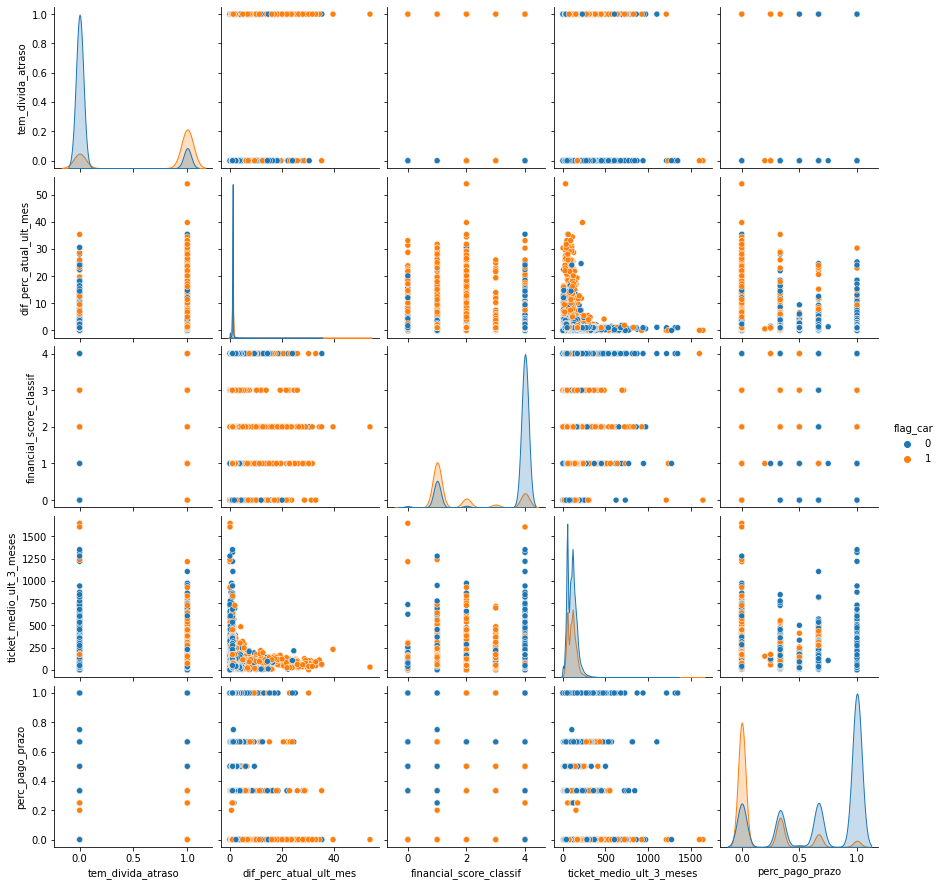

In [9]:
plt.figure(figsize=(24, 24))
sns.pairplot(data=df,
             x_vars=['tem_divida_atraso', 'dif_perc_atual_ult_mes', 'financial_score_classif', 'ticket_medio_ult_3_meses', 'perc_pago_prazo'],
             y_vars=['tem_divida_atraso', 'dif_perc_atual_ult_mes', 'financial_score_classif', 'ticket_medio_ult_3_meses', 'perc_pago_prazo'],
             hue='flag_car')
plt.show()

Comentários:

O pairplot da biblioteca Seaborn é uma forma ótima de plotar duas variáveis com a intenção de compará-las e identificar algum relacionamento entre elas.

- Linha 1:
    - No gráfico (x=0, y=4) - Contando de 0 a 4 - é possível notar uma grande densidade de clientes com dívida em atraso e entrada no CAR. Mediante à visão de negócios, percebe-se uma forte necessidade de melhoria da cobrança de clientes com algum histórico de inadimplência.
    - Nos demais gráficos da primeira linha não é possível identificar alguma relação explícita entre as variáveis e o fato da fatura ter entrada no CAR.


- Linha 2:
    - No quarto gráfico é possível notar uma maior quantidade de faturas inadimplentes (laranja) em menores ticket médios, porém com maior aumento percentual de faturamento. Esse comportamento é interessante, pois indica que clientes com um histórico de faturamento mais baixo que tenham tido algum aumento no seu faturamento atual tendem a não pagar as faturas atuais.
    - No quinto gráfico é possível identificar "bons consumidores". A última coluna representa aqueles clientes que pagaram 100% do seu faturamento dos últimos 3 meses no prazo possui a maior razão de pontos azuis por total de pontos (analisando visualmente), ou seja, suas faturas são pagas em dia. O comportamento dos bons consumidores é especialmente indicado pela baixa presença de pontos laranjas no topo da última coluna, o que indica que mesmo com o aumento percentual do faturamento entre o mês anterior e o atual, o cliente ainda sim paga sua fatura em dia.
    
    
- Linha 3:
    - O gráfico central (terceiro) apresenta uma maior curva de densidade azul (faturas adimplentes) no score financeiro 4 que indica perfil adimplente, portanto, indicando o bom funcionamento do score financeiro.
    
    
- Linha 4:
    - O último gráfico novamente aponta para os "bons consumidores" na última coluna indicando 100% de pagamento no prazo.
    
    
- Linha 5:
    - O último gráfico demonstra que a densidade de faturas inadimplentes (laranja) decresce com o aumento do percentual de pagamento no prazo histórico. Isto é, os picos são cada vez menos altos andando pra direita, indicando um bom comportamento dos dados de acordo com o esperado. O pequeno pico laranja mais a direita demonstra algumas faturas cujo perfil histórico de pagamento no prazo era perfeito (100%) porém o cliente atrasou o pagamento da fatura.
    - Ainda no último gráfico a curva de densidade azul reforça que clientes com melhor perfil tendem a não deixar o prazo de pagamento da fatura escorregar, porém os três outros picos de área semalhante indicam que o percentual histórico de pagamento no prazo não define se o cliente pagará a fatura no prazo ou não.

### 1.5 - Histogramas

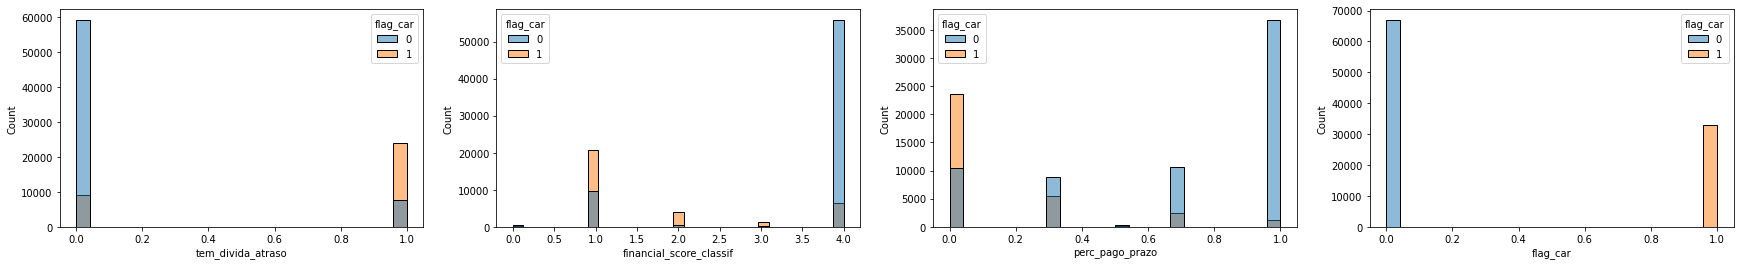

In [10]:
cols = ['tem_divida_atraso', 'financial_score_classif', 'perc_pago_prazo', 'flag_car']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(30, 4))
for ax, col in zip(axes, cols):
    sns.histplot(ax=ax, data=df[cols], x=col, hue='flag_car')
plt.show()

Comentários:

- Gráfico 1: A grande maioria dos cliente sem nenhuma dívida em atraso pagou a fatura em dia.

- Gráfico 2: O score 4-Adimplente possui a maior contagem de clientes que pagaram suas faturas em dia. Esse comportamento já havia sido qualitativamente identificado nas análises acima.

- Gráfico 3: Alguns clientes com 100% de pagamento no prazo deixaram de pagar sua fatura em dia. A maioria esmagadora dos clientes que pagfam 100% no prazo não deixam de pagar suas faturas em dia. O extremo oposto representado pelos clientes que pagam 0% no prazo possui uma forte presença de clientes que pagaram suas faturas antes de entrar no CAR (barra azul). Possivelmente esses clientes não possuem tempo suficiente de base (i.e.: 3 meses de faturamento), logo seu perfil foi preenchido com 0%. Isso indica que clientes novos pagaram suas faturas em dia.

- Gráfico 4: Apresentação de desbalanceamento da base. Esse problema será adereçado a seguir.

## 2. Preprocessamento

### 2.1 - Balanceamento

In [11]:
group = df.groupby(by=['flag_car'], as_index=False).flag_car.count()
group['% Total'] = group['flag_car']/group['flag_car'].sum()
group

,flag_car,% Total
0,66999,0.66999
1,33001,0.33001


In [12]:
n_samples = group.flag_car.min() # Pegando a maior quantidade de amostras possíveis pra conseguir uma proporção 50-50
balanced_df = pd.DataFrame()
for label in df.flag_car.unique():
    balanced_df = pd.concat([balanced_df, df.loc[df.flag_car == label].sample(n=n_samples, replace=False, random_state=SEED, axis=0)], axis=0)

In [13]:
balanced_df.groupby(by=['flag_car'], as_index=False).agg({'flag_car': 'count'})

,flag_car
0,33001
1,33001


<AxesSubplot:xlabel='flag_car', ylabel='Count'>

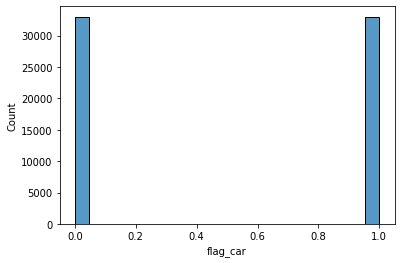

In [14]:
sns.histplot(balanced_df.flag_car)

Comentários:

O balanceamento da base é muitas vezes necessário, pois a presença esmagadora de uma classe em um problema de classificação binário pode levar ao desenvolvimento de um classificador "preguiçoso", isto é, um classificador que mesmo chutando 100% na classe x alcançará alta acurácia, pois essa é a classe de maior presença na base.

No caso, se o classificador chutasse 0 em 100% dos dados de treino, ele alcançaria 67% de acurácia do problema.

In [15]:
df = balanced_df.copy(deep=True)

### 2.2 - Selecionando os melhores atributos

In [16]:
# Selecionando as melhores features
best_features = [
    'dias_ate_vencimento', 'valor_fatura', 'dif_perc_atual_ult_mes', 'ticket_medio_ult_3_meses',
    'tem_divida_atraso', 'divida_antiga_sobre_fatura', 'idade_base_cliente', 'idade_base_conta',
    'financial_score_classif', 'empresa_grupo', 'perc_pago_prazo'
]

df = df[best_features + ['flag_car']].copy(deep=True) # Pegando o label

### 2.3 - Normalizando os atributos numéricos

In [17]:
scaler = MinMaxScaler()
scale_cols = [
    'dias_ate_vencimento', 'valor_fatura', 'ticket_medio_ult_3_meses',
    'idade_base_cliente', 'idade_base_conta', 'dif_perc_atual_ult_mes',
    'divida_antiga_sobre_fatura'
]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

### 2.4 - Aplicando One-hot Encoding nos atributos categóricos

In [18]:
cat_cols = ['financial_score_classif', 'empresa_grupo']

one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore')
one_hot.fit_transform(df[cat_cols])

X = pd.concat([df.drop(columns=cat_cols+['flag_car']).reset_index(drop=True), pd.DataFrame(one_hot.transform(df[cat_cols]))], axis=1).astype(float).values
y = df['flag_car'].astype(float).values

In [19]:
# Recuperando as colunas após o Onehot Encoding
X_cols = list(df.drop(columns=cat_cols+['flag_car']).columns)
for col, cat in [(c.split('_')[0].replace('x', ''), c.split('_')[1]) for c in one_hot.get_feature_names()]:
    X_cols.append(f'{cat_cols[int(col)]}_{cat}')
X_cols

['dias_ate_vencimento',
 'valor_fatura',
 'dif_perc_atual_ult_mes',
 'ticket_medio_ult_3_meses',
 'tem_divida_atraso',
 'divida_antiga_sobre_fatura',
 'idade_base_cliente',
 'idade_base_conta',
 'perc_pago_prazo',
 'financial_score_classif_0',
 'financial_score_classif_1',
 'financial_score_classif_2',
 'financial_score_classif_3',
 'financial_score_classif_4',
 'empresa_grupo_0',
 'empresa_grupo_1',
 'empresa_grupo_2',
 'empresa_grupo_5']

### 2.5 - Separando a base em 80% para treino e 20% para validação

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 3 - Treinando os modelos

### 3.1 - Treinando múltiplos classificadores

In [21]:
classifiers = [
    RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=SEED),
    AdaBoostClassifier(n_estimators=500, learning_rate=0.75, random_state=SEED),
    GradientBoostingClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, verbose=0, random_state=SEED),
    ExtraTreesClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, verbose=0, n_jobs=-1, random_state=SEED),
    LogisticRegression(random_state=SEED, max_iter=1000),
    xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss'),
    SVC(kernel='rbf', gamma=10, C=0.1)
]

In [22]:
times = []
preds = []
for i, clf in enumerate(classifiers):
    s = time.time()
    clf.fit(X_train, y_train)
    preds.append(clf.predict(X_val))
    t = datetime.timedelta(seconds=(time.time() - s))
    times.append(t)
    print(f'{type(clf).__name__} - Accuracy Score: {round(accuracy_score(y_true=y_val, y_pred=preds[i]), 4)} - Training Time: {str(t)}')
print(f'\nTotal training time: {str(sum(times, datetime.timedelta()))}')

RandomForestClassifier - Accuracy Score: 0.8577 - Training Time: 0:00:06.131075
AdaBoostClassifier - Accuracy Score: 0.8569 - Training Time: 0:00:27.342740
GradientBoostingClassifier - Accuracy Score: 0.853 - Training Time: 0:04:48.427438
ExtraTreesClassifier - Accuracy Score: 0.8577 - Training Time: 0:00:07.021259
LogisticRegression - Accuracy Score: 0.8488 - Training Time: 0:00:00.815940
XGBClassifier - Accuracy Score: 0.8636 - Training Time: 0:00:03.313490
SVC - Accuracy Score: 0.8584 - Training Time: 0:02:13.678349

Total training time: 0:07:46.730291


Comentários:

Todos os classificadores obtiveram acurácias próximas. O melhor classificador foi o XGBoostingClassifier que utiliza o método de floresta randômica juntamente à minimização do erro através da técnica do gradiente descendente. Esse classificador é muito famoso por ser vitorioso em várias competições do Kaggle e possuir alta versatilidade de uso na indústria. Outro ponto importante é a construção do modelo ter sido feita de modo a otimizar o uso de hardware na hora do treino. Isso pode ser visto pelo pequeno tempo de treino. Os resultados acima, portanto, justificam sua fama.

#### Visualizando uma árvore do modelo RandomForest

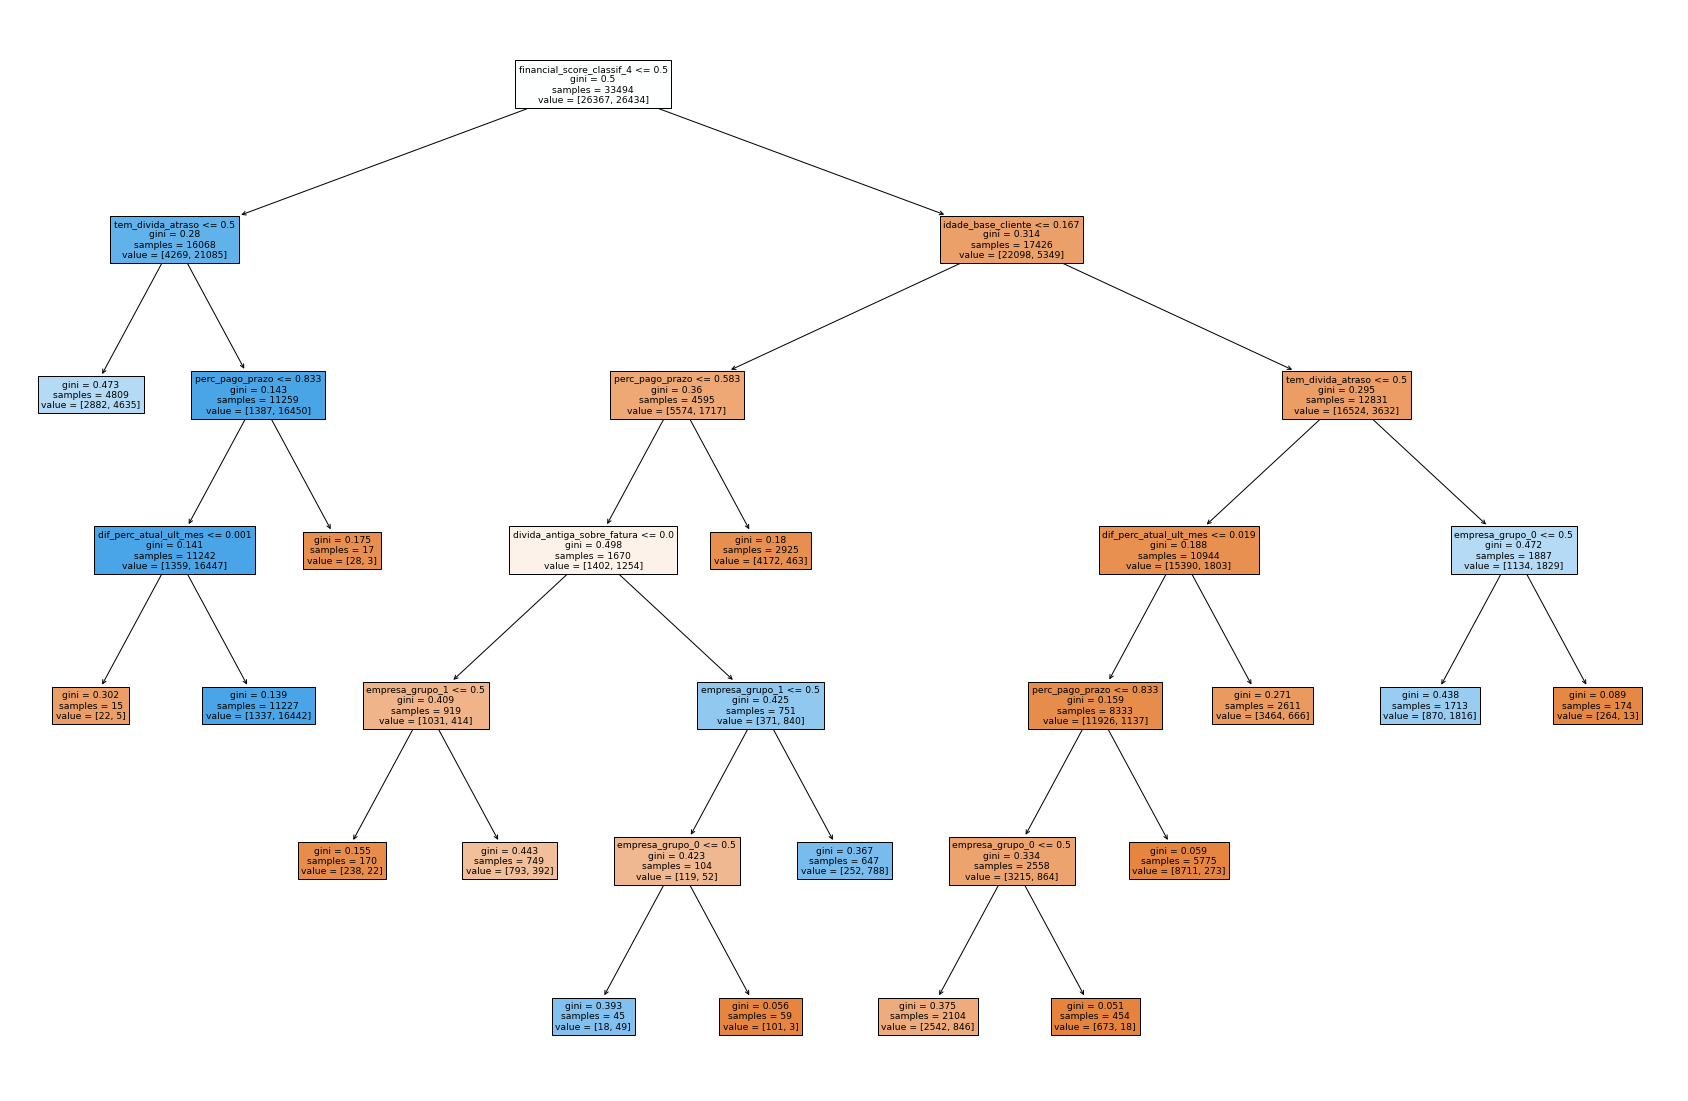

In [23]:
# Plotando uma árvore de decisão
plt.figure(figsize=(30, 20))
rf = classifiers[0]
tree.plot_tree(rf.estimators_[0], feature_names=X_cols, filled=True);

#### 3.1.1 - Avaliando a importância dos atributos

In [24]:
features = X_cols
feature_importances = []
clf_name = []
for clf in classifiers[:-3]:
    feature_importances.append([round(f, 3) for f in clf.feature_importances_])
    clf_name.append(type(clf).__name__)
importances_df = pd.DataFrame(data=np.asarray(feature_importances).T, columns=clf_name, index=features)
importances_df

,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
dias_ate_vencimento,0.013,0.056,0.030,0.019
valor_fatura,0.002,0.170,0.075,0.001
dif_perc_atual_ult_mes,0.010,0.314,0.076,0.001
ticket_medio_ult_3_meses,0.001,0.178,0.083,0.001
tem_divida_atraso,0.195,0.000,0.000,0.270
divida_antiga_sobre_fatura,0.206,0.204,0.141,0.001
idade_base_cliente,0.003,0.016,0.041,0.004
idade_base_conta,0.005,0.020,0.035,0.005
perc_pago_prazo,0.158,0.016,0.046,0.199
financial_score_classif_0,0.001,0.006,0.002,0.002


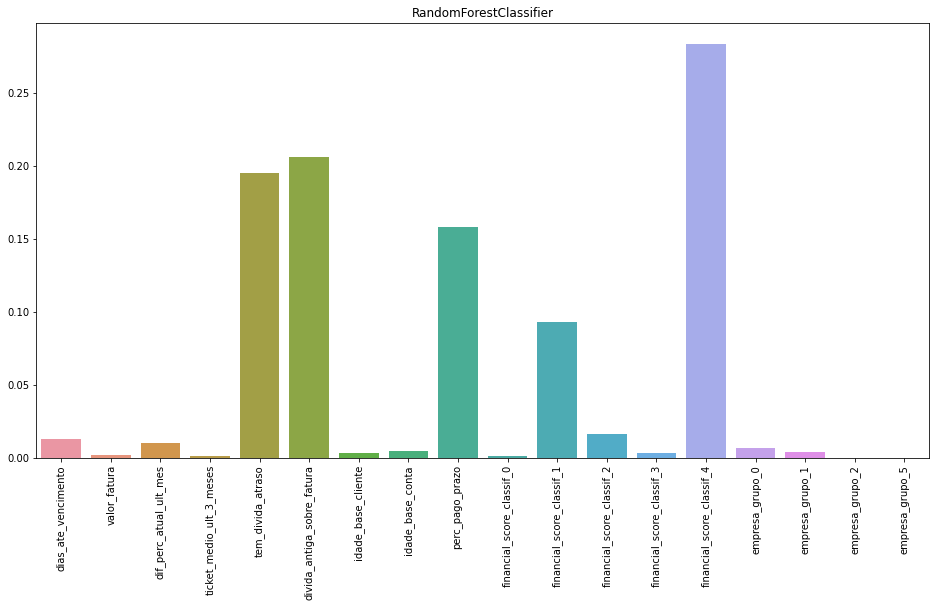

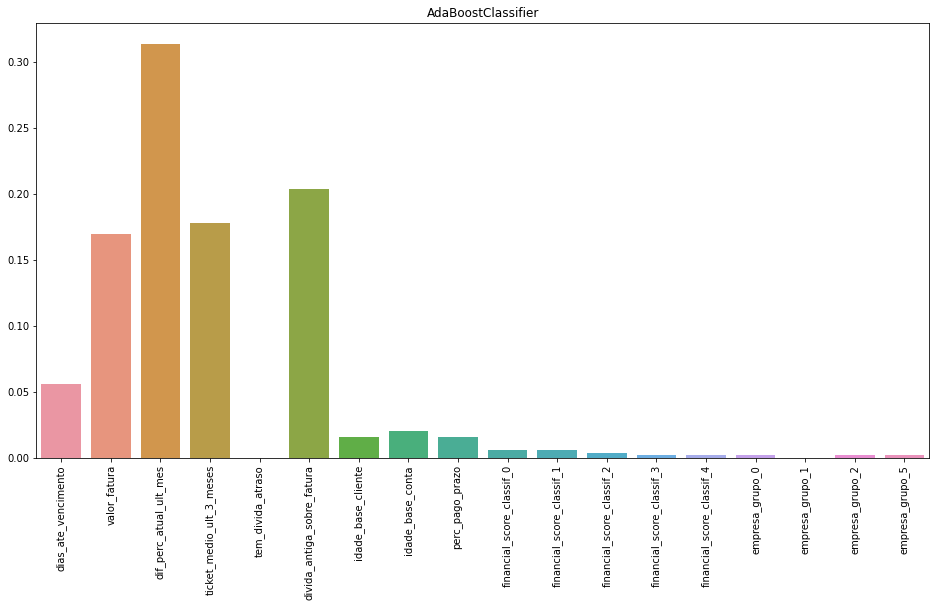

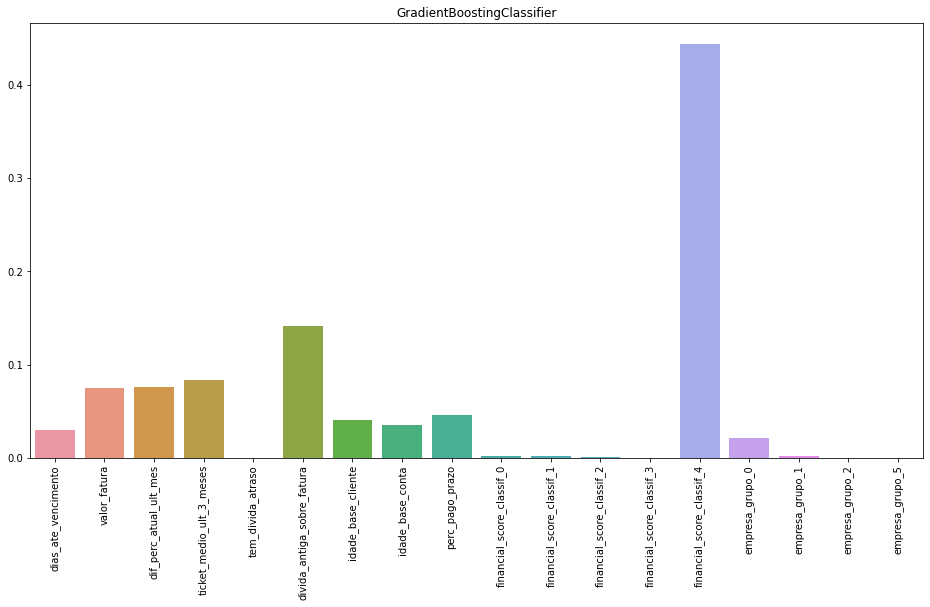

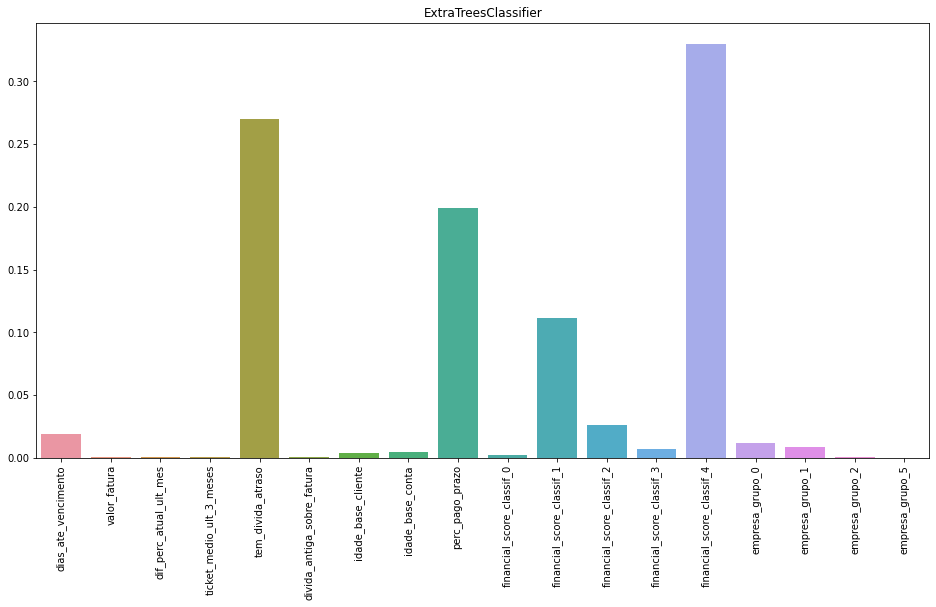

In [25]:
for col in importances_df:
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importances_df.index, y=importances_df[col].values)
    plt.title(label=col)
    plt.xticks(rotation=90)

Comentários:

Nota-se de imediato que determinados atributos possuem maior importância para alguns algoritmos que outros.

### 3.2 - Hard Voting Classifier

In [26]:
X_train_2L = []
X_val_2L = []
for clf in classifiers:
    X_train_2L.append(clf.predict(X_train))
    X_val_2L.append(clf.predict(X_val))
X_train_2L = np.asarray(X_train_2L).T
X_val_2L = np.asarray(X_val_2L).T

In [27]:
X_train_2L[:10]

array([[0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [28]:
gbm = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
gbm.fit(X_train_2L, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [29]:
print(f'Accuracy Score: {accuracy_score(y_true=y_val, y_pred=gbm.predict(X_val_2L))}')

Accuracy Score: 0.8530414362548292


Comentários:

A tecnica de hard voting consiste no treino de uma camada de classificadores distintos e posteriormente o treino de um classificador para gerar predições em cima das predições dos classificadores da primeira camada. O objetivo dessa tecnica é melhorar a acurácia global do modelo permitindo que classificadores que gerem melhores predições em determinadas porções de dados compensem uma predição errônea de um classificador mais fraco nessas porções de dados. Portanto, o classificador final balancea as fraquezas individuais de cada classificador.

No entando, o resultado acima foi ligeiramente inferior ao melhor classificador dentre os modelos previamente treinados. A partir desse resultado pode-se inferir que a grande maioria dos classificadores está cometendo o mesmo erro em determinadas porções dos dados.

### 3.3 - Stacking Classifier

In [30]:
firstLayer = [
    RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=SEED),
    AdaBoostClassifier(n_estimators=500, learning_rate=0.75, random_state=SEED),
    SVC(kernel='rbf', gamma=10, C=0.1)
]

secondLayer = [
    GradientBoostingClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, verbose=0, random_state=SEED),
    ExtraTreesClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, verbose=0, n_jobs=-1, random_state=SEED),
    SVC(kernel='linear', gamma=10, C=0.1)
]

thirdLayer = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, objective='binary:logistic') # Blender

In [31]:
# Dividindo a base de treino em 30% para o treino da primeira camada, 30% para a segunda, 30% para a terceira e finalmente 10% para validação 
processed_data = pd.DataFrame(
    data=np.concatenate((X, np.reshape(y, newshape=(-1, 1))), axis=1),
    columns=X_cols+['flag_car'])

train_1L, train_2L, train_3L, val_set = np.split(
    ary=processed_data.sample(frac=1, random_state=SEED),
    indices_or_sections=[int(0.3*len(df)), int(0.6*len(df)), int(0.9*len(df))])

In [32]:
print(train_1L.shape)
print(train_2L.shape)
print(train_3L.shape)
print(val_set.shape)

(19800, 19)
(19801, 19)
(19800, 19)
(6601, 19)


In [33]:
X_train_1L, y_train_1L = train_1L.drop(columns='flag_car').values, train_1L['flag_car'].values
X_train_2L, y_train_2L = train_2L.drop(columns='flag_car').values, train_2L['flag_car'].values
X_train_3L, y_train_3L = train_3L.drop(columns='flag_car').values, train_3L['flag_car'].values
X_val_set, y_val_set = val_set.drop(columns='flag_car').values, val_set['flag_car'].values

In [34]:
print(X_train_1L.shape, y_train_1L.shape)
print(X_train_2L.shape, y_train_2L.shape)
print(X_train_3L.shape, y_train_3L.shape)
print(X_val_set.shape, y_val_set.shape)

(19800, 18) (19800,)
(19801, 18) (19801,)
(19800, 18) (19800,)
(6601, 18) (6601,)


#### 3.3.1 - Treinando a primeira camada

In [35]:
for clf in firstLayer:
    clf.fit(X_train_1L, y_train_1L)

#### 3.3.2 - Treinando a segunda camada

In [36]:
firstLayer_preds = []
for clf in firstLayer:
    firstLayer_preds.append(clf.predict(X_train_2L))
firstLayer_preds = np.asarray(firstLayer_preds).T

for clf in secondLayer:
    clf.fit(firstLayer_preds, y_train_2L)

#### 3.3.3 - Treinando a terceira camada

In [37]:
firstLayer_preds = []
for clf in firstLayer:
    firstLayer_preds.append(clf.predict(X_train_3L))
firstLayer_preds = np.asarray(firstLayer_preds).T

secondLayer_preds = []
for clf in secondLayer:
    secondLayer_preds.append(clf.predict(firstLayer_preds))
secondLayer_preds = np.asarray(secondLayer_preds).T

thirdLayer.fit(secondLayer_preds, y_train_3L)

[14:43:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### 3.3.4 - Realizando predições em cima da parcela de validação

In [38]:
firstLayer_preds = []
for clf in firstLayer:
    firstLayer_preds.append(clf.predict(X_val_set))
firstLayer_preds = np.asarray(firstLayer_preds).T

secondLayer_preds = []
for clf in secondLayer:
    secondLayer_preds.append(clf.predict(firstLayer_preds))
secondLayer_preds = np.asarray(secondLayer_preds).T

thirdLayer_preds = thirdLayer.predict(secondLayer_preds)

In [39]:
print(f'Accuracy Score: {accuracy_score(y_true=y_val_set, y_pred=thirdLayer_preds)}')

Accuracy Score: 0.8568398727465536


#### 3.3.5 - Empilhando as camadas em um classificador final treinado

In [40]:
def stacking_classifier_predict(X_test):
    firstLayer_preds = []
    for clf in firstLayer:
        firstLayer_preds.append(clf.predict(X_test))
    firstLayer_preds = np.asarray(firstLayer_preds).T

    secondLayer_preds = []
    for clf in secondLayer:
        secondLayer_preds.append(clf.predict(firstLayer_preds))
    secondLayer_preds = np.asarray(secondLayer_preds).T

    return thirdLayer.predict(secondLayer_preds)

Comentários:

Um Stacking Classifier consiste na sobreposição de camadas de classificadores, porém em oposição ao Voting Classifier, suas camadas são treinadas com dados inéditos, ou seja, cada camada é treinada com uma parcela diferente de dados. 
O treino das camadas é realizado da seguinte forma:

1 - Divide-se os dados em n parcelas + 1 parcela de validação, sendo n o número de camadas do metaclassificador. Ex.: Para um metaclassificador de 3 camadas, divide-se a base de treino em 3 parcelas + 1 parcela para a validação final do modelo.

2 - É realizado o treino da primeira camada normalmente em cima da primeira parcela dos dados.

3 - Para treinar a segunda camada, predições são geradas pela primeira camada em cima da segunda parcela dos dados. Esse conjunto de predições é então utilizado para treinar a segunda camada.

4 - Para treinar a terceira camada o processo é análogo ao treino da segunda camada. Utiliza-se a terceira parcela dos dados para gerar predições pela primeira camada, essas predições são enviadas para a segunda camada (treinada anteriormente) que gerará um novo conjunto de predições. Finalmente esse novo conjunto de predições é utilizado para treinar a camada final do metaclassificador.

5 - Ao final, utiliza-se o conjunto de validação para aferir a acurácia do modelo final.

A partir do resultado acima, nota-se uma leve melhora na acurácia do metaclassificador em comparação com o Voting Classifier. No entanto, a acurácia ainda permanece inferior à melhor acurária obtida nos classificadores convencionais.

### 3.4 - Redes Neurais

#### 3.4.1 - Funções auxiliares

In [41]:
def create_keras_model(input_data, n_hidden=1, n_neurons=20, activation='relu', dropout=0, optimizer='adam', loss='binary_crossentropy'):
    model = models.Sequential()
    model.add(layers.Dense(n_neurons, activation=activation, input_shape=(input_data.shape[1],)))
    if dropout:
        model.add(layers.Dropout(dropout))
    for l in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['acc'])
    return model

def plot_model_results(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26, 8))
    for ax, train, val, title, legend in zip(axes,
                                             [loss, acc],
                                             [val_loss, val_acc],
                                             ['Training Loss', 'Training Accuracy'],
                                             ['Loss', 'Accuracy']):
        ax.plot(epochs, train, 'b-', label=f'Training {legend}')
        ax.plot(epochs, val, 'r-', label=f'Validation {legend}')
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(legend)
        ax.legend()
    plt.show()

#### 3.4.2 - Instanciando diferentes configurações

In [42]:
DNN_models = [
    create_keras_model(input_data=X_train, n_hidden=0, n_neurons=50, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=0, n_neurons=100, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=0, n_neurons=200, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=1, n_neurons=50, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=1, n_neurons=100, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=2, n_neurons=50, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=3, n_neurons=50, activation='relu', dropout=0.3),
    create_keras_model(input_data=X_train, n_hidden=4, n_neurons=50, activation='relu', dropout=0.3)
]

In [43]:
hist = []
for m in DNN_models:
    hist.append(m.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0))

In [44]:
for i, m in enumerate(DNN_models):
    print(f'Model {i} Accuracy Score: {accuracy_score(y_true=y_val, y_pred=np.round(m.predict(X_val), decimals=0))}')

Model 0 Accuracy Score: 0.8597075979092493
Model 1 Accuracy Score: 0.8600863570941595
Model 2 Accuracy Score: 0.8600106052571775
Model 3 Accuracy Score: 0.8594045905613211
Model 4 Accuracy Score: 0.8604651162790697
Model 5 Accuracy Score: 0.8601621089311415
Model 6 Accuracy Score: 0.8572077872888417
Model 7 Accuracy Score: 0.8597833497462314


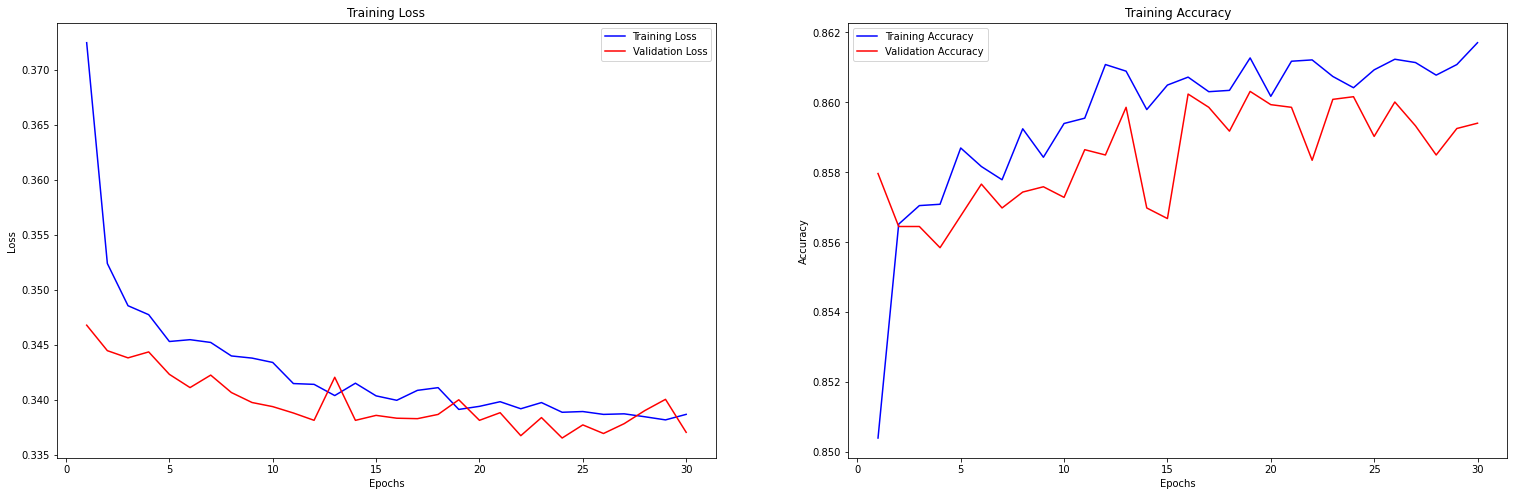

In [45]:
plot_model_results(hist[3])

Comentários:

Foram treinadas diferentes configurações de redes neurais. Todos os modelos mantiveram uma performance semelhante com uma acurácia de 86% próxima aquela obtida utilizando XGBoost. Foi construído o gráfico de histórico de treino da melhor configuração com uma camada oculta de 50 neurônios. Nota-se grande proximidade das curvas de acurácia de treino e validação. Contudo, a curva de treino permanece ligeiramente acima daquela de validação, indicando que o modelo está sofrendo overfitting da base de treino. Portanto, o modelo não está sendo capaz de generalizar e performar igualmente bem com uma base nunca vista.

### 3.5 - Salvando os modelos

#### 3.5.1 - Salvando as instâncias utilizadas durante o preprocessamento

In [46]:
with open('StandardScaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('OnehotEncoder.pkl', 'wb') as f:
    pickle.dump(one_hot, f)

In [47]:
for clf in classifiers:
    with open(f'{type(clf).__name__}.pkl', 'wb') as f:
        pickle.dump(clf, f)
    
for i, model in enumerate(DNN_models):
    model.save(f'DNN_model_{i}.h5')

Comentários:

O Após o treino de diversos modelos e otimização de hiperparâmetros, o melhor modelo é aquele de maior performance e com a maior capacidade generalizadora. Este deve ser armazenado para posteriormente ser carregado em um pipeline de dados que o utilizará para gerar predições em tempo real dos dados.

## 4 - Aplicando os modelos na base de teste

### 4.1 - Carregando as instâncias de preprocessamento e modelos

In [48]:
with open('StandardScaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
with open('OnehotEncoder.pkl', 'rb') as f:
    one_hot = pickle.load(f)

In [49]:
my_classifiers = [
    'RandomForestClassifier.pkl',
    'AdaBoostClassifier.pkl',
    'GradientBoostingClassifier.pkl',
    'ExtraTreesClassifier.pkl',
    'LogisticRegression.pkl',
    'XGBClassifier.pkl',
    'SVC.pkl'
]

classifiers = []
for clf in my_classifiers:
    with open(clf, 'rb') as f:
        classifiers.append(pickle.load(f))
        
        
DNN_models = []
for file in os.listdir():
    if os.path.splitext(file)[1] == '.h5':
        DNN_models.append(models.load_model(file))

### 4.2 - Carregando a base de teste

In [50]:
test_data = pd.read_csv('test_data.csv', sep=';')

In [51]:
test_data.head()

,periodo,dt_emissao,dt_vencimento,bill_period,dt_ativacao_conta,dias_ate_vencimento,bill_disp_meth,valor_fatura,dif_perc_atual_ult_mes,ticket_medio_ult_3_meses,empresa_grupo,dt_ativacao_cliente,email_cadastrado,financial_score_classif,dsc_frm_notificacao_ptl,numero_recebimento_sms_cadastrado,genero_cliente,internet_casa,internet_escritorio,tem_divida_atraso,divida_antiga_sobre_fatura,idade_base_cliente,idade_base_conta,perc_pago_prazo,flag_car
0,202107,2021-07-03,2021-07-16,3,2015-03-13,13,1,171.03,1.133925,150.830000,1,2014-04-13,1,4,1,1,2,-3,-3,0,0.000000,7,6,1,0
1,202107,2021-07-03,2021-07-16,3,2018-12-18,13,1,106.30,1.024084,102.473333,1,2011-02-15,0,4,1,1,2,-3,-3,0,0.000000,10,3,1,0
2,202107,2021-07-03,2021-07-16,3,2018-04-23,13,1,85.36,0.854539,100.976666,1,2002-03-13,1,1,1,1,2,-3,-3,0,0.000000,19,3,0,1
3,202107,2021-07-12,2021-07-28,7,2020-06-22,16,1,117.18,1.065563,112.193333,1,2019-08-20,1,4,1,1,2,-3,-3,0,0.000000,2,1,"0,666666666666667",0
4,202107,2021-07-12,2021-07-28,7,2021-04-20,16,1,49.12,1.078138,38.690000,1,2018-04-11,1,0,1,1,2,-3,-3,1,0.927524,3,0,0,1


### 4.3 - Preprocessando a base de teste

In [52]:
test_data.drop(columns=drop_cols, inplace=True)

In [53]:
test_data = test_data[best_features + ['flag_car']].copy(deep=True) # Pegando o label

In [54]:
test_data['perc_pago_prazo'] = test_data['perc_pago_prazo'].str.replace(',', '.').astype(float)

In [55]:
# Normalizando
test_data[scale_cols] = scaler.transform(test_data[scale_cols])

In [56]:
# One-hot Encoding
X_test = pd.concat([test_data.drop(columns=cat_cols+['flag_car']).reset_index(drop=True), pd.DataFrame(one_hot.transform(test_data[cat_cols]))], axis=1).astype(float).values
y_test = test_data['flag_car'].astype(float).values

### 4.4 - Gerando predições

In [57]:
preds = []
for i, clf in enumerate(classifiers):
    preds.append(clf.predict(X_test))
    print(f'{type(clf).__name__} Accuracy Score: {accuracy_score(y_true=y_test, y_pred=preds[i])}')

RandomForestClassifier Accuracy Score: 0.81681
AdaBoostClassifier Accuracy Score: 0.81779
GradientBoostingClassifier Accuracy Score: 0.80797
ExtraTreesClassifier Accuracy Score: 0.82311
LogisticRegression Accuracy Score: 0.82726
XGBClassifier Accuracy Score: 0.81442
SVC Accuracy Score: 0.81381


In [58]:
for i, m in enumerate(DNN_models):
    print(f'Model {i} Accuracy Score: {accuracy_score(y_true=y_test, y_pred=np.round(m.predict(X_test), decimals=0))}')

Model 0 Accuracy Score: 0.81749
Model 1 Accuracy Score: 0.81608
Model 2 Accuracy Score: 0.81803
Model 3 Accuracy Score: 0.81285
Model 4 Accuracy Score: 0.81608
Model 5 Accuracy Score: 0.81625
Model 6 Accuracy Score: 0.82649
Model 7 Accuracy Score: 0.82065


Comentários:

Durante a modelagem do problema, o classificador que mais se destacou, mesmo que por uma pequena margem, foi o XGBoost. No entanto, os resultados acima indicam que seu destaque deveu-se ao overfitting nos dados de treinamento, pois esse classificador não obteve a liderança. Curiosamente, o classificador de melhor desempenho na base de teste foi a regressão logística, cuja acurácia na validação foi de 84,88% sendo a pior dentre todos os modelos treinados. Através dos resultados pode-se dizer que a regressão logística foi o modelo com a maior capacidade de generalização dentre os demais.

Finalmente, todos os modelos treinados obtiveram uma acurácia na faixa de 80,0% a 82,7%. O fato das acurácias de diferentes modelos terem permanecido próximas pode indicar que a natureza do problema é muito complexa e não-linear impossibilitando a identificação de padrões escondidos nos dados. Como próximos passos, seria possível a busca ou criação de mais atributos através da engenharia de atributos ou coleta de mais dados seguida de uma etapa de otimização de hiperparâmetros. No entanto, uma acurácia de 80% pode ser aproveitada pelo time de negócios para a geração de um algorítmo que envie mensagens automáticas para os clientes com maior probabilidade de não pagar as faturas próximas à data de vencimento.